In [63]:
import numpy as np

INVIVO_DATA_PATH = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_data.npz'
INVIVO_RAW_PATH = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat'

In [64]:
from scipy import signal, io
from lfp_prediction.config import params
from tqdm.notebook import tqdm

oscBand = np.array([15,30])
z, a = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
x = []
y1 = []
for arr in tqdm(mat):
    if arr[0].shape[0] < (params.PREVIOUS_TIME + params.LOOK_AHEAD):
        continue
    i = 0
    t = params.PREVIOUS_TIME
    k = params.LOOK_AHEAD
    while arr[0].shape[0] > t+k:
        x.append(arr[0][i:t,:])
        y1.append(signal.lfilter(z, a, arr[0][t:t+k,:], axis=0))
        # y1.append(arr[0][t:t+k,:])
        i += params.PREVIOUS_TIME
        t += params.PREVIOUS_TIME

inputs = np.stack(x, axis=0)
labels = np.stack(y1, axis=0)
print(inputs.shape)
print(labels.shape)


  0%|          | 0/63 [00:00<?, ?it/s]

(7119, 2048, 1)
(7119, 100, 1)


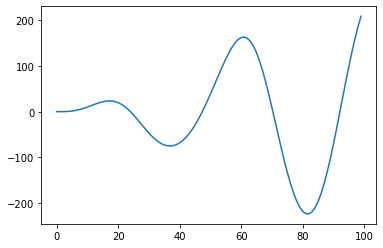

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(100), labels[0,:,0])
plt.show()

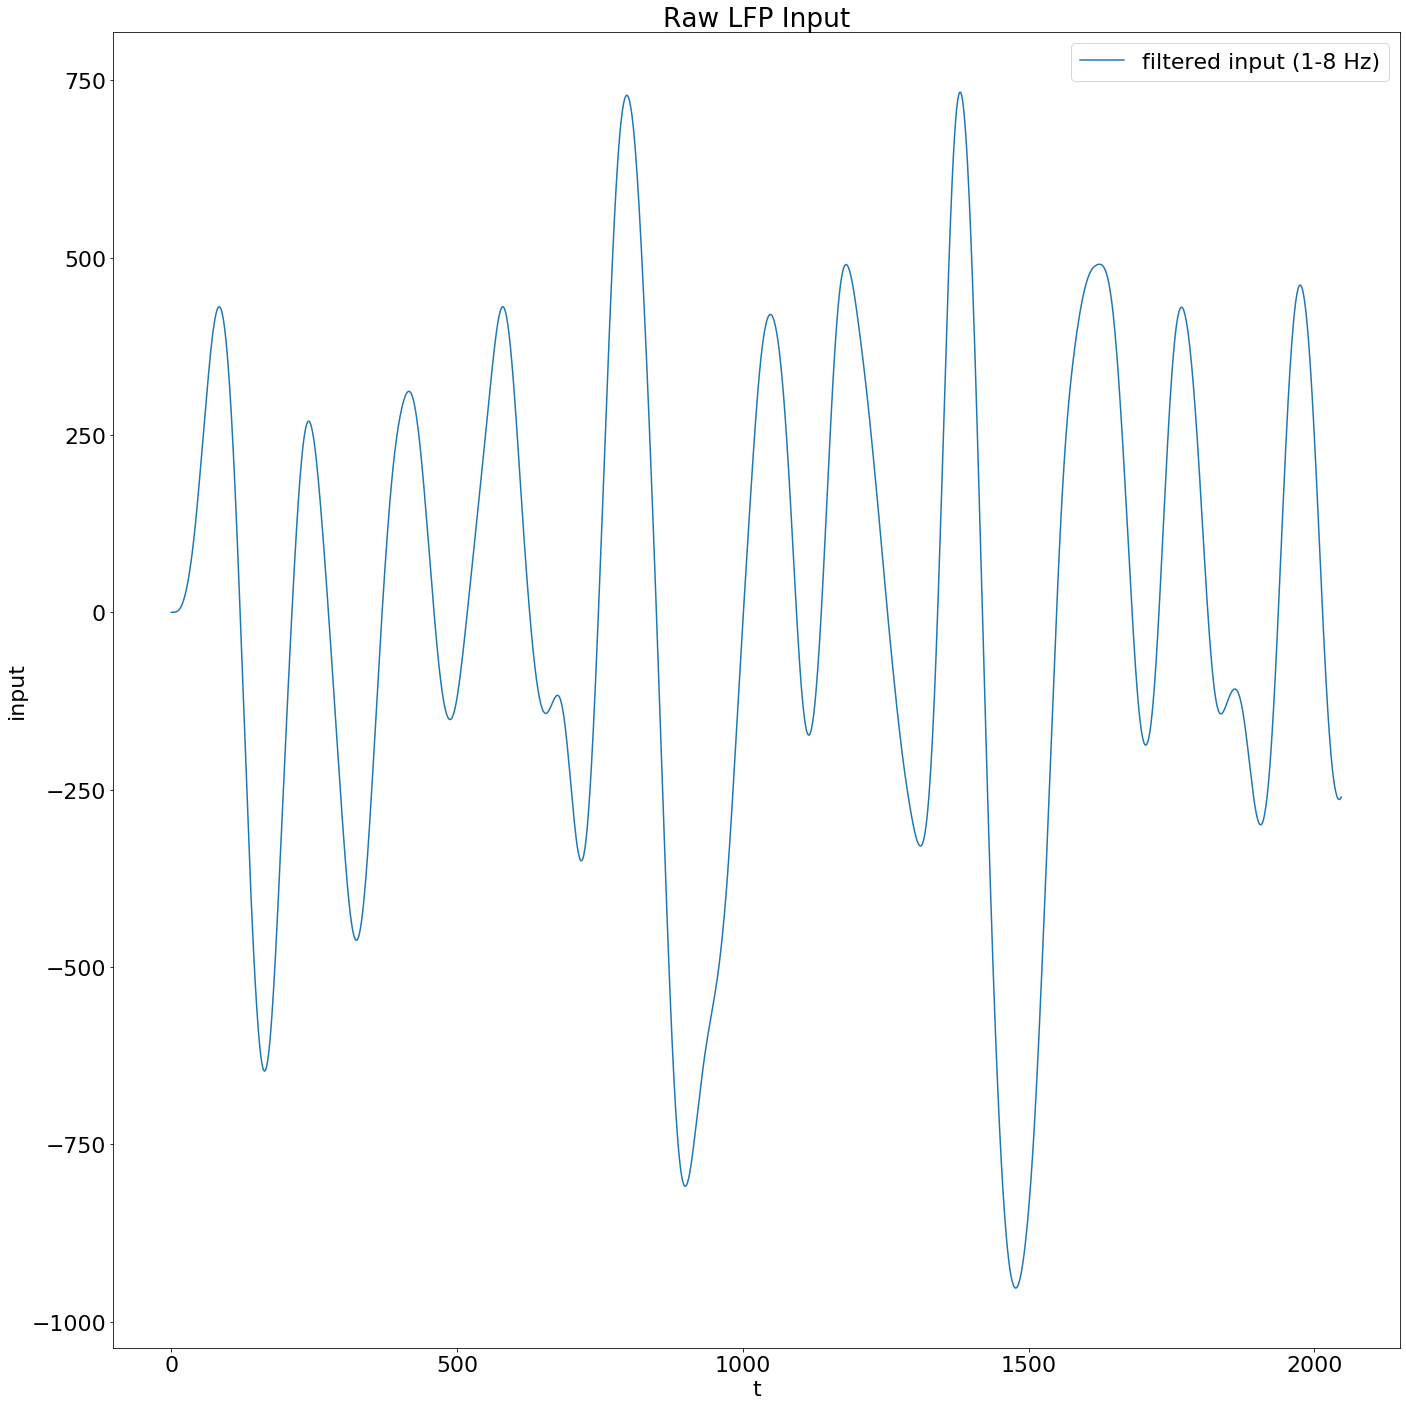

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 22

fig, axs = plt.subplots(1,1)

# axs = plt.subplots()

t = np.arange(0, inputs.shape[1], 1)

oscBand = np.array([1,8])
z1, a1 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

oscBand = np.array([8,15])
z2, a2 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

oscBand = np.array([15,30])
z3, a3 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

oscBand = np.array([30,55])
z4, a4 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

oscBand = np.array([55,100])
z5, a5 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

oscBand = np.array([100,250])
z6, a6 = signal.butter(4, oscBand, btype='bandpass', output='ba', fs=1000)

ylow1 = signal.lfilter(z1, a1, inputs[0,:,0], axis=0)
ylow2 = signal.lfilter(z2, a2, inputs[0,:,0], axis=0)
ylow3 = signal.lfilter(z3, a3, inputs[0,:,0], axis=0)
ylow4 = signal.lfilter(z4, a4, inputs[0,:,0], axis=0)
ylow5 = signal.lfilter(z5, a5, inputs[0,:,0], axis=0)
ylow6 = signal.lfilter(z6, a6, inputs[0,:,0], axis=0)

temp = ylow1 + ylow2 + ylow3 + ylow4 + ylow5

# axs.plot(t[500:1024], inputs[0,500:1024,0], label='raw input')
# axs.plot(t[500:1024], temp[500:], label='summed filtered input')

start_time = 0
end_time = 2048
axs.plot(t[start_time:end_time], ylow1[start_time:end_time], label='filtered input (1-8 Hz)')
# axs.plot(t[start_time:end_time], ylow2[start_time:end_time], label='filtered input (8-15 Hz)')
# axs.plot(t[start_time:end_time], ylow3[start_time:end_time], label='filtered input (15-30 Hz)')
# axs.plot(t[start_time:end_time], ylow4[start_time:end_time], label='filtered input (30-55 Hz)')
# axs.plot(t[start_time:end_time], ylow5[start_time:end_time], label='filtered input (55-100 Hz)')
# axs.plot(t[start_time:end_time], ylow6[start_time:end_time], label='filtered input (100-250 Hz)')
axs.set_xlabel('t')
axs.set_ylabel('input')
axs.set_title('Raw LFP Input')
axs.legend()

fig.tight_layout()
plt.show()

/home/matt/venvs/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


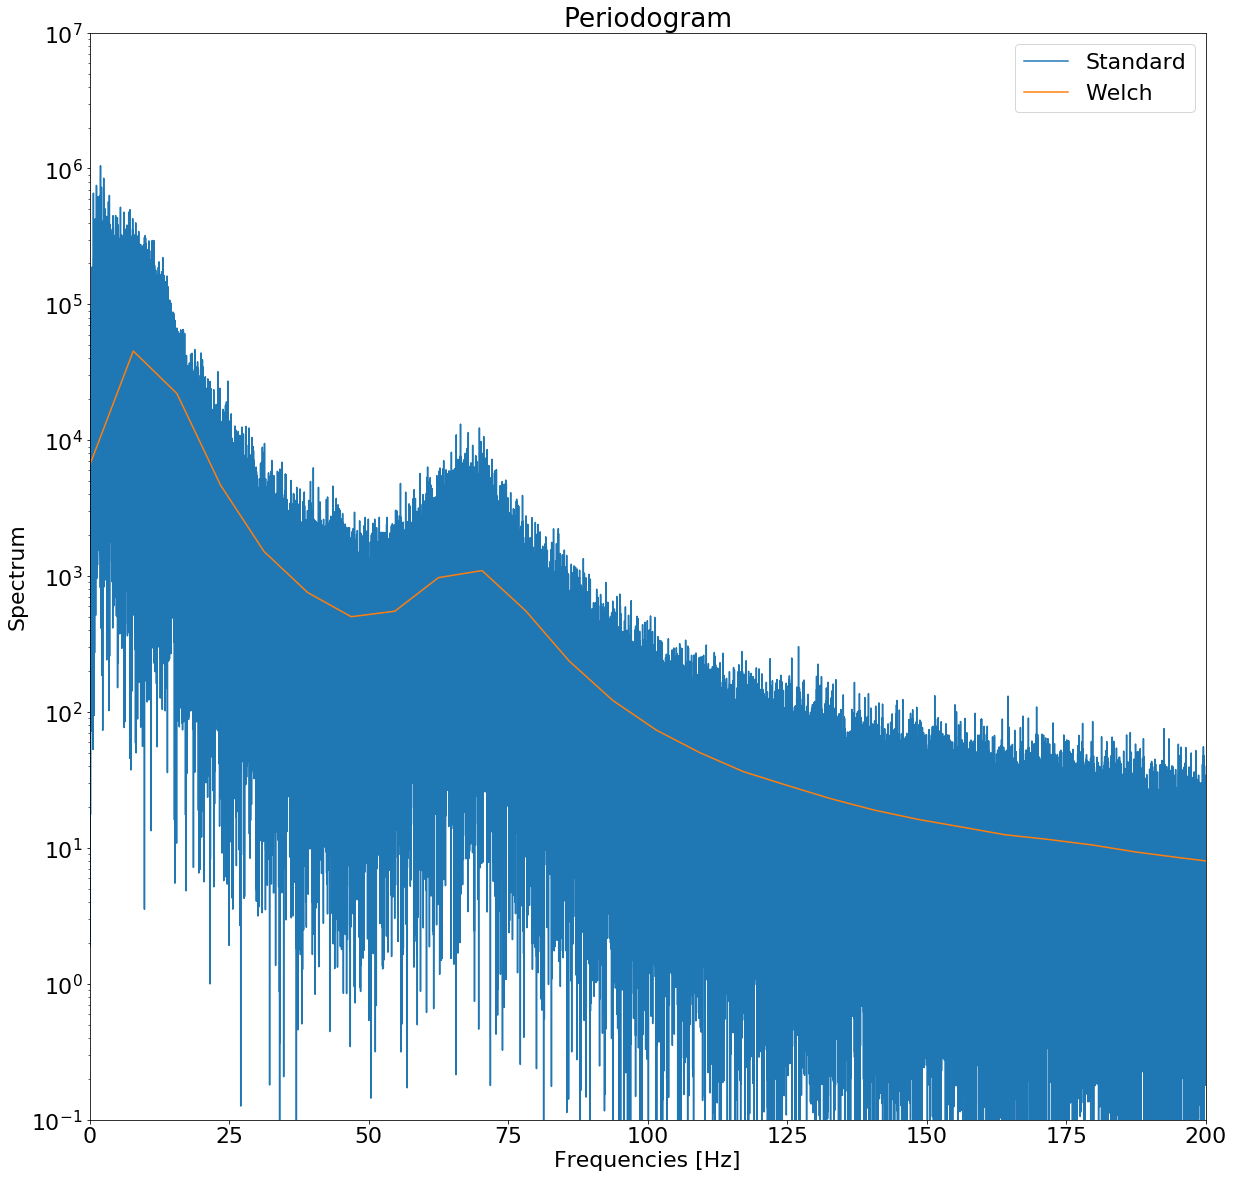

In [67]:
from scipy.signal import periodogram, welch

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 22

axs = plt.subplots()

r_lfp = arr[0]

f, psd = periodogram(r_lfp, fs=1000, window='hamming', scaling='density', axis=0)
f_w, psd_w = welch(r_lfp, fs=1000, window='hamming', nperseg=128, scaling='density', axis=0)
plt.semilogy(f, psd, label='Standard')
plt.semilogy(f_w, psd_w, label='Welch')
plt.ylim([1e-1, 1e7])
plt.xlim([0, 200])
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.legend()
plt.show()

In [68]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

data = np.transpose(inputs, (0, 2, 1))
labels = np.transpose(labels, (0, 2, 1))

print(data.shape)
print(labels.shape)

split_idx = 5340  #12000

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

(7119, 1, 2048)
(7119, 1, 100)


In [69]:
import torch.nn as nn
from tqdm.notebook import tqdm

def train_model(model,training_loader,validation_loader,epochs,device):
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    loss_func = nn.MSELoss()
    decay_rate = .99995 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    validation_loss, training_loss = [], []

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                if params.RECURRENT_NET:
                    x = torch.transpose(x, 2, 1)
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
                training_loss.append(train_loss)
            else:
                val_loss = running_loss
                validation_loss.append(val_loss)

        # shows total loss
        if epoch%5 == 0:
            tqdm.write('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))
    return training_loss, validation_loss

In [70]:
import copy
from lfp_prediction.models.LFPNet import FCN

epochs = 50

model = FCN(in_size=2048, h_size=500, out_size=100)
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = train_model(model, train_data, valid_data, epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

[1,    56] train loss: 5285804.567383 val loss: 1509870.724609
[6,    56] train loss: 3831554.083008 val loss: 1337746.513672
[11,    56] train loss: 3710023.083008 val loss: 1302383.876953
[16,    56] train loss: 3629696.497070 val loss: 1303102.261719
[21,    56] train loss: 3599268.399414 val loss: 1306936.159180
[26,    56] train loss: 3559874.074219 val loss: 1285883.518555
[31,    56] train loss: 3535868.483398 val loss: 1303463.442383
[36,    56] train loss: 3510972.749023 val loss: 1297096.968750
[41,    56] train loss: 3481654.902344 val loss: 1295274.980469
[46,    56] train loss: 3473789.549805 val loss: 1301346.379883


In [71]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()


print(y.shape)
print(output.shape)

(32, 1, 100)
(32, 1, 100)


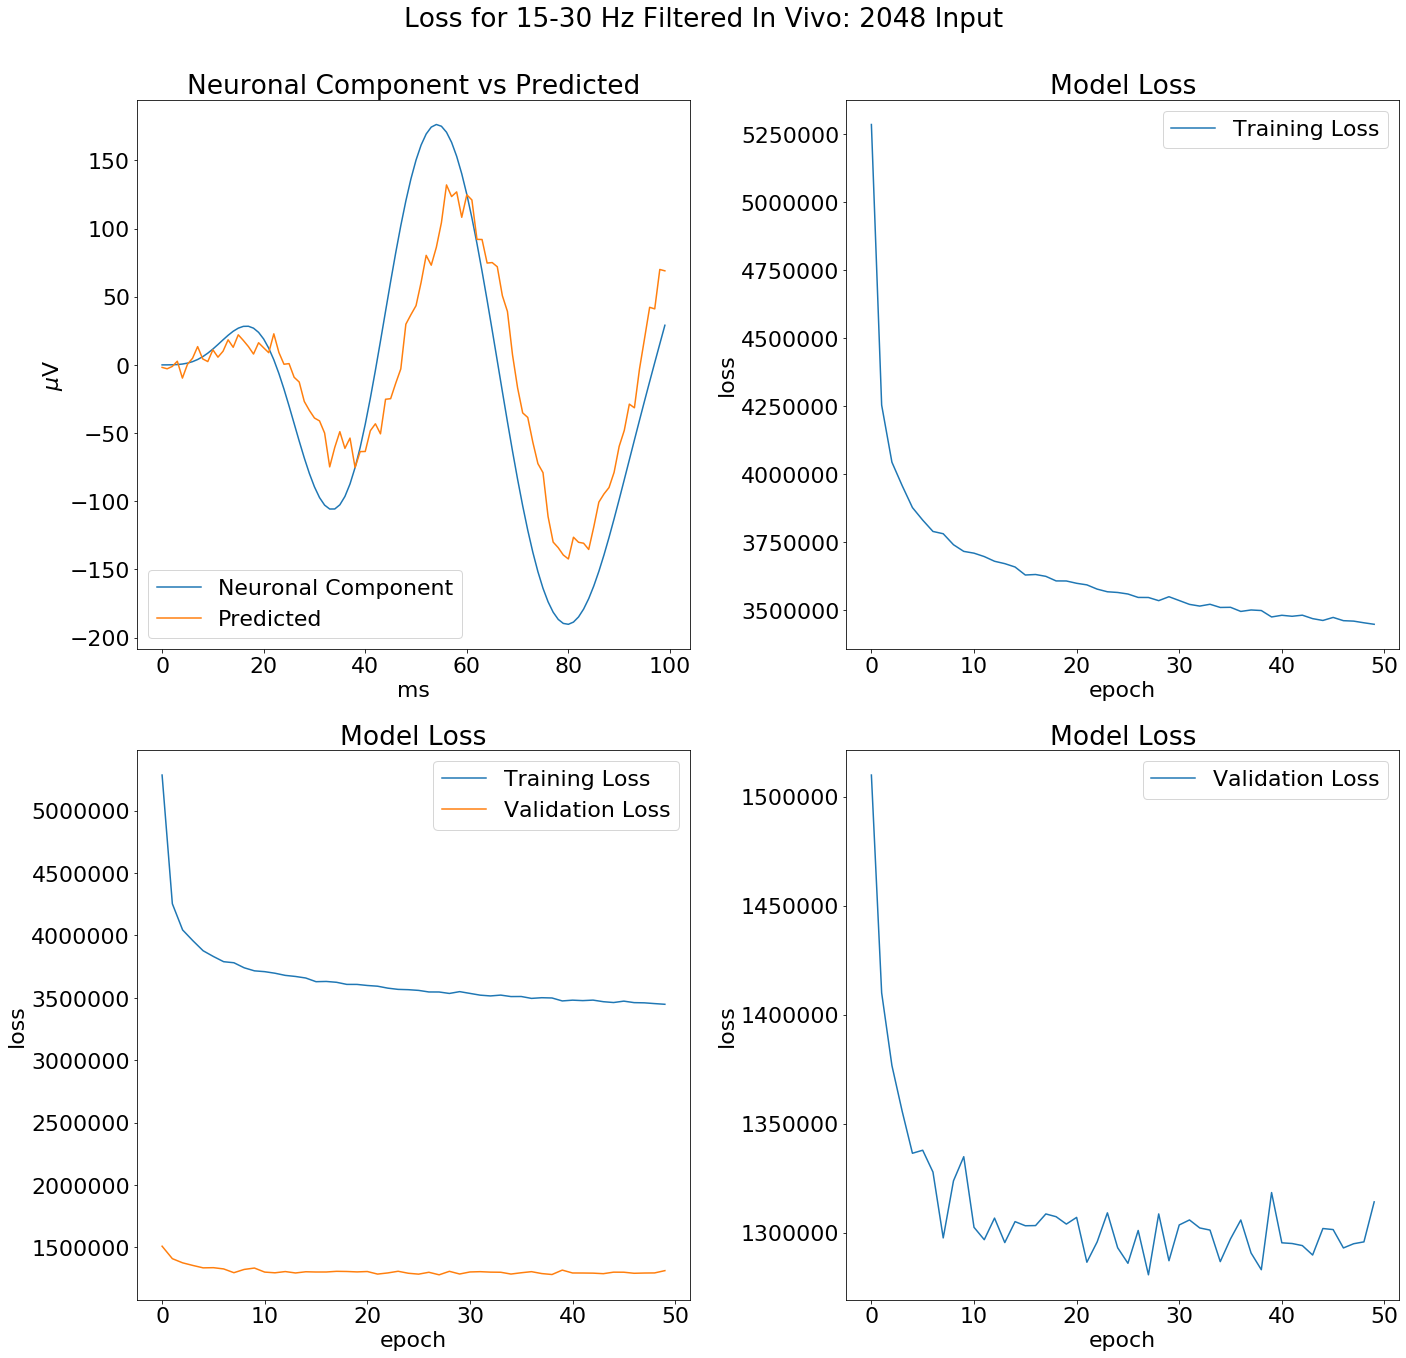

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 22

fig, axs = plt.subplots(2,2)

fig.suptitle('Loss for 15-30 Hz Filtered In Vivo: 2048 Input')

t = np.arange(0, 100, 1)

time_var = 100

# axs[0,0].plot(t, data[200001,0,:100], label='Raw White Noise')
axs[0,0].plot(t, y[0,0,:], label='Neuronal Component')
axs[0,0].plot(t, output[0,0,:], label='Predicted')

axs[0,0].set_xlabel('ms')
axs[0,0].set_ylabel(r'$\mu$V')
axs[0,0].set_title('Neuronal Component vs Predicted')
# axs[0,0].set_ylim(bottom=-.0001, top=.0001)
axs[0,0].legend(loc='best')

axs[1,0].plot(np.arange(epochs), np.array(t_loss), label='Training Loss')
axs[1,0].plot(np.arange(epochs), np.array(v_loss), label='Validation Loss')
axs[1,0].set_xlabel('epoch')
axs[1,0].set_ylabel('loss')
axs[1,0].set_title('Model Loss')
# axs[1,0].set_ylim(bottom=-0.001, top=0.4)
# axs[1,0].set_xlim(left=-0.001, right=epochs)
axs[1,0].legend(loc='best')

axs[0,1].plot(np.arange(epochs), np.array(t_loss), label='Training Loss')

axs[0,1].set_xlabel('epoch')
axs[0,1].set_ylabel('loss')
axs[0,1].set_title('Model Loss')
# axs[0,1].set_ylim(bottom=0.2, top=0.3)
# axs[0,1].set_xlim(left=-0.001, right=epochs)
axs[0,1].legend(loc='best')

axs[1,1].plot(np.arange(epochs), np.array(v_loss), label='Validation Loss')

axs[1,1].set_xlabel('epoch')
axs[1,1].set_ylabel('loss')
axs[1,1].set_title('Model Loss')
# axs[1,1].set_ylim(bottom=-0.001, top=0.2)
# axs[1,1].set_xlim(left=-0.001, right=epochs)
axs[1,1].legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()